# Исследование качества работы приложения компании из сферы продуктового ритейла.

Объект анализа - данные о продажах магазина на различных этапах воронки, а также результаты A/A/B-эксперимента, проведенного для изучения влияния шрифта в приложении на количество транзакций.
 
Цель исследования - проанализировать данные о поведении пользователей приложения и сделать вывод о возможных проблемах, с которыми сталкиваются пользователи на том или ином этапе совершения покупки. По результатам А/А/В теста определить приводит ли изменение шрифтов в прилоении к статистически значимому увеличению конверсии в покупки. 

План работы:

    1 - Загрузка и обзор данных 
    2 - Предобработка данных
    3 - Исследовательский анализ
    4 - Анализ воронки продаж
    5 - Изучение результатов А/А/В - теста
    6 - Вывод

###  Загрузка и обзор данных 

In [86]:
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')


In [169]:
raw_data = pd.read_csv("/logs_exp.csv", delim_whitespace=True)
raw_data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [170]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [171]:
raw_data.duplicated().sum()

413

В данных представлена информация о 244126 событиях, которые пользователи совершили на сайте. В датасете 413 дубликата.
Названия столбцов и типы событий нужно переименовать. Типы данных можно оптимизировать.

### Предобработка данных

In [172]:
# Переименуем столбцы

data = raw_data.copy()
data.columns = ['event', 'id', 'timestamp', 'group']
data.head()

,event,id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [173]:
# Удалим дубликаты

data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

In [174]:
# Изменим формат некоторых полей.
# Добавим столбец datetime и даты

data['id'] = pd.to_numeric(data['id'], downcast = 'signed')
data['group'] = pd.to_numeric(data['group'], downcast = 'signed')
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s') 
data['date'] = data['datetime'].dt.date
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   id         243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  int16         
 4   datetime   243713 non-null  datetime64[ns]
 5   date       243713 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(2), object(2)
memory usage: 9.8+ MB


In [175]:
# Заменим название событий на более короткие для простоты работы

data['event'] = data['event'].replace('MainScreenAppear', 'main')
data['event'] = data['event'].replace('OffersScreenAppear', 'offer')
data['event'] = data['event'].replace('CartScreenAppear', 'cart')
data['event'] = data['event'].replace('PaymentScreenSuccessful', 'typ')
data['event'] = data['event'].replace('Tutorial', 'tutorial')

In [176]:
data['date'] = data['date'].astype('datetime64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   id         243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  int16         
 4   datetime   243713 non-null  datetime64[ns]
 5   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int16(1), int64(2), object(1)
memory usage: 9.8+ MB


### Исследовательский анализ

In [177]:
events_amount = data['event'].count()

print('Всего событий в логе: {}'.format(events_amount))

Всего событий в логе: 243713


In [178]:
users_amount = data["id"].nunique()
print('Уникальных пользователей в логе: {}'.format(users_amount))

Уникальных пользователей в логе: 7551


Построим распределение числа событий по пользователям

In [179]:
event_per_user = data.groupby('id')['event'].count().to_frame()
event_per_user.head()

,event
id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


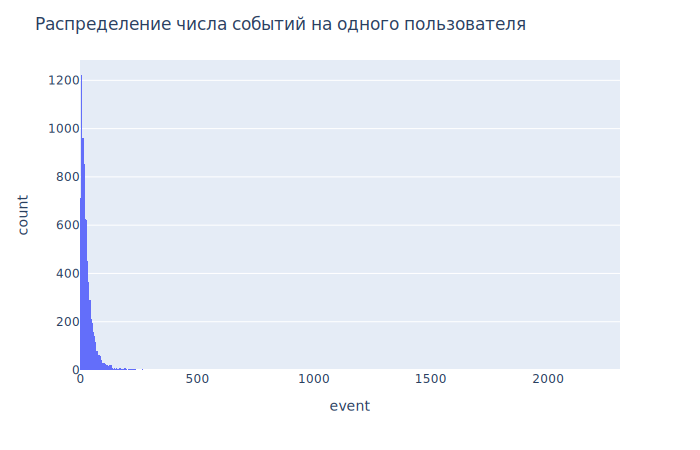

In [180]:
fig = px.histogram(event_per_user, x = 'event')
fig.update_layout(title_text="Распределение числа событий на одного пользователя")

fig.show("svg")

Распределение сильно скошено вправо, но функционал библиотеки plotly позволяет выбрать интересующуюнас область на графике

In [181]:
print('В среднем на одного пользователя приходится {:.2f} событий'.format(events_amount/users_amount))

В среднем на одного пользователя приходится 32.28 событий


Т.к. распределение сильно скошено и имеет очень большие выбросы до 2500 событий на пользователя, то более показательной характерной мерой распределения будет медиана.

In [182]:
print('Медианное число событий на пользователя равно {}'.format(event_per_user['event'].median()))

Медианное число событий на пользователя равно 20.0


Исследуем временные данные

In [183]:
print('Дата самого раннего события в логе: {}'.format(data['date'].min()))
print('Дата самого позднего события в логе: {}'.format(data['date'].max()))

Дата самого раннего события в логе: 2019-07-25 00:00:00
Дата самого позднего события в логе: 2019-08-07 00:00:00


Построим гистограмму числа событий по времени

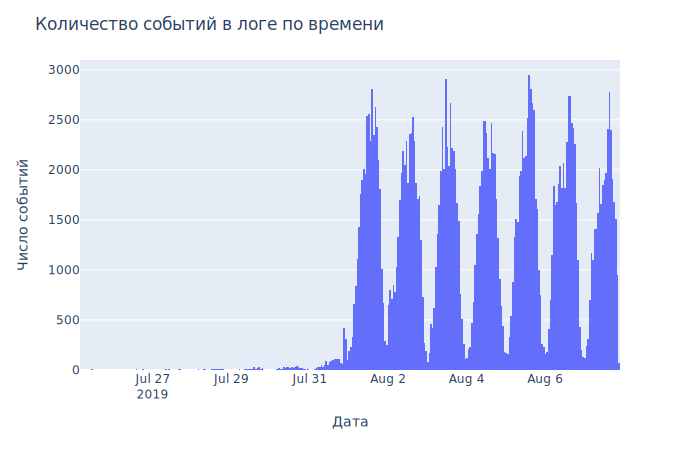

In [184]:
fig = px.histogram(data, x = 'datetime', labels=dict(x="Дата", y="Число событий") )
fig.update_layout(
    title = 'Количество событий в логе по времени',
)
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Число событий')
fig.show("svg")

На графике хорошо видно, что данных за первую половину исследуемого периода значительно меньше, чем во вторую. Скорее всего сбор данных начался 1го августа и закончилс 8го августа. Более ранние данные - результат запаздылой загрузки данных по некоторым пользователям. 
Рассмотрим данные за первую неделю.

In [185]:
old_data = data[data['datetime'] < '2019-08-01']
print('За первую неделю собрана информация о {} событиях из общего количества в {}'.format(old_data.shape[0], data.shape[0]))
print('Что составляет {:.2%}'.format(old_data.shape[0] / data.shape[0]))
                

За первую неделю собрана информация о 2826 событиях из общего количества в 243713
Что составляет 1.16%


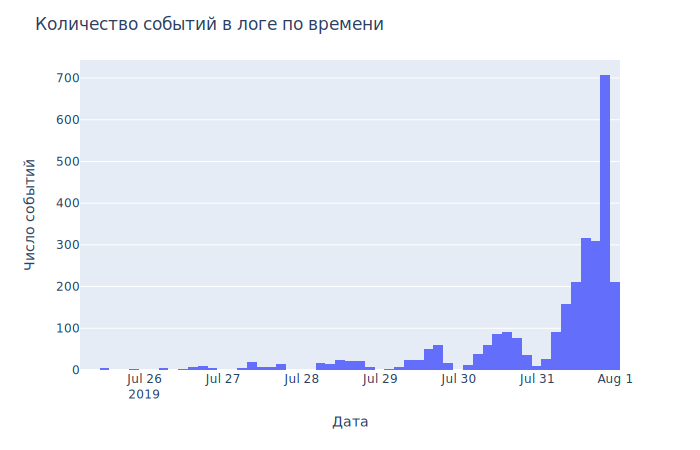

In [186]:
fig = px.histogram(old_data, x = 'datetime', labels=dict(x="Дата", y="Число событий") )
fig.update_layout(
    title = 'Количество событий в логе по времени',
)
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Число событий')
fig.show("svg")

Общий объем старых данных составляет 1,16% от общего датасета. Мы не потеряем много данных если отбросим этот период и оставим только данные за одну неделю наблюдений с 1 по 8 августа.

In [187]:
data = data[~data['datetime'].isin(old_data['datetime'])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      240887 non-null  object        
 1   id         240887 non-null  int64         
 2   timestamp  240887 non-null  int64         
 3   group      240887 non-null  int16         
 4   datetime   240887 non-null  datetime64[ns]
 5   date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int16(1), int64(2), object(1)
memory usage: 11.5+ MB


In [188]:
users_amount = data["id"].nunique()
print('Уникальных пользователей в логе: {}'.format(users_amount))

Уникальных пользователей в логе: 7534


In [189]:
old_data['id'].nunique(), round((old_data['id'].nunique()/7551)*100,2), round((7534/7551)*100,2)

(1451, 19.22, 99.77)

Мы потеряли информацию о действиях 1451 пользователей, что составляет 19,22% от исходных данных. При этом уникальных пользователей в данных осталость 7534 из 7551, т.е 99.77%

Проверим, из каких групп есть информация о пользователях в данных

In [190]:
data.groupby('group')['id'].nunique()

group
246    2484
247    2513
248    2537
Name: id, dtype: int64

#### Вывод

После очистки датасета от старых данных мы определили, что эксперимент проводиля с 1 по 8 августа 2019г. В нем приняли участие 7534 пользователь приложения. У нас есть информация о 243713 событиях, которые совершили эти люди, с медианой 20 событий на человека.
События в группах праспределены совольно равномерно, по 77 - 84 тысячи .

### Анализ воронки продаж

In [191]:
# Рассмотрим какие события есть в логах

print(data['event'].value_counts())

print()

main        117328
offer        46333
cart         42303
typ          33918
tutorial      1005
Name: event, dtype: int64



In [192]:
# Посчитаем число уникальных пользователей, совершивших каждое событие

unique_users_event = data.groupby('event')['id'].nunique().sort_values(ascending = False).to_frame()
unique_users_event

,id
event,
main,7419
offer,4593
cart,3734
typ,3539
tutorial,840


In [193]:
unique_users_amount = data["id"].nunique()
print('Число уникальных пользователей -',unique_users_amount)

Число уникальных пользователей - 7534


In [194]:
# Расчитаем долю пользователей, совершивших каждое событие

unique_users_event['share'] = (unique_users_event['id']/unique_users_amount*100).round(2)
unique_users_event

,id,share
event,,
main,7419,98.47
offer,4593,60.96
cart,3734,49.56
typ,3539,46.97
tutorial,840,11.15


Для дальнейшего анализу нужно определить шаги воронки по которым проходят пользователи при совершении покупки.
Наиболее вероятным сценарием являются следующие три шага:

    1) Пользователель посещает главную страницу
    2) Пользователель посещает страницу предложения
    3) Пользователь переходит в корзину
    4) Пользователь переходит на страницу оплата совершена, мы будем называть ее страница "Спасибо!"

Страницы с предложениями и обучением не являются обязательными

Изучим воронку более детально

In [195]:
unique_users = [unique_users_event['id'][0],unique_users_event['id'][1],unique_users_event['id'][2],unique_users_event['id'][3]]
print('Число уникальных пользователей на шагах воронки :',unique_users)

Число уникальных пользователей на шагах воронки : [7419, 4593, 3734, 3539]


In [196]:
# Всего событий по типу

users = data.groupby('event')['id'].count().sort_values(ascending = False).to_frame()
users

,id
event,
main,117328
offer,46333
cart,42303
typ,33918
tutorial,1005


In [197]:
# Расчитаем conversion rate с предыдущего шага воронки

conversion = [100, round(unique_users[1]/unique_users[0],2)*100, round(unique_users[2]/unique_users[1],2)*100, round(unique_users[3]/unique_users[2],2)*100]
conversion

[100, 62.0, 81.0, 95.0]

Построим диаграмму перехода пользователей по шагам воронки

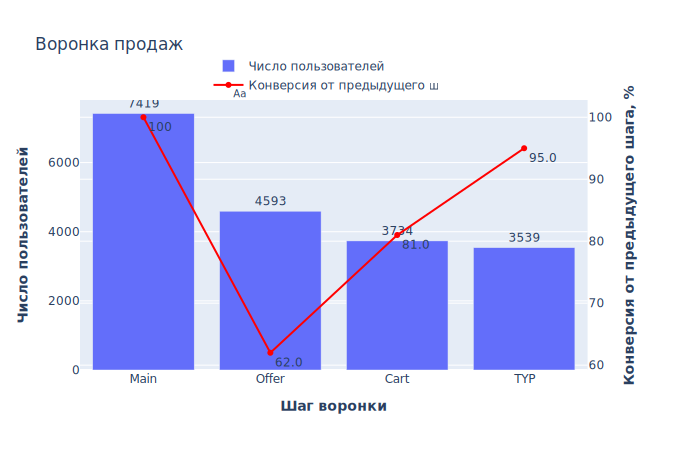

In [198]:
fig = make_subplots( specs=[[{"secondary_y": True}]])


fig.add_trace(go.Bar( x= ('Main', 'Offer', 'Cart', 'TYP'), y=[unique_users[0] , unique_users[1] , unique_users[2], unique_users[3]], 
                         text=unique_users, textposition="outside", name='Число пользователей'),
    secondary_y=False)


fig.add_trace(go.Scatter(x= ('Main', 'Offer', 'Cart', 'TYP'), y=conversion, line=dict(color='red'), 
                         text=conversion, textposition="bottom right", name='Конверсия от предыдущего шага'), secondary_y=True)

# fig.update_layout(showlegend=False)
fig.update_layout(
    width=900,
    height=600,
    legend=dict(
    yanchor="top",
    y=1.18,
    xanchor="center",
    x=0.45
))
fig.update_traces(mode="lines+markers+text",selector=dict(type='scatter'))
fig.update_traces(text=unique_users, selector=dict(type='bar')) 
fig.update_xaxes(title_text="<b>Шаг воронки</b>")
fig.update_layout(title_text="Воронка продаж")
fig.update_yaxes(title_text="<b>Число пользователей</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Конверсия от предыдущего шага, %</b>", secondary_y=True)
fig.show("svg")

Хорошо видно, что больше всего (38% пользователей) теряется при переходе с главной страницы на страницу предложения
Скорее всего это связано с непониманием пользователей что же такое страница предложения.

In [199]:
print('Из всех посетителей c главной страницы приложения до покупки доходит {:.1%}.'.format(unique_users[2]/unique_users[0]))

Из всех посетителей c главной страницы приложения до покупки доходит 50.3%.


Это очень большая конверсия

Исследуем дополнительно изменение конверсии со временем

In [200]:
unique_user_df = data.drop_duplicates(subset=['id','event'])
user_time = unique_user_df.groupby(['date'])['event'].value_counts().to_frame().reset_index(0)
user_time.head(10)

,date,event
event,,
main,2019-08-01,3545
offer,2019-08-01,2050
cart,2019-08-01,1510
typ,2019-08-01,1372
tutorial,2019-08-01,155
main,2019-08-02,1460
offer,2019-08-02,874
cart,2019-08-02,798
typ,2019-08-02,757


In [201]:
conv = pd.DataFrame(index = ['main', 'cart', 'typ'])
for date in user_time['date'].unique():
    conv[date] = user_time[user_time['date']==date]['event']
conversion_time = conv.T
conversion_time


,main,cart,typ
2019-08-01,3545,1510,1372
2019-08-02,1460,798,757
2019-08-03,823,503,510
2019-08-04,580,332,335
2019-08-05,446,260,260
2019-08-06,352,198,184
2019-08-07,213,133,121


In [202]:
conversion_time['cr_1_3']=conversion_time['typ']/conversion_time['main']
conversion_time['std_1_3']=round(np.sqrt((conversion_time['cr_1_3']*(1-conversion_time['cr_1_3']))/conversion_time['main']),4)
conversion_time = conversion_time.reset_index()
conversion_time['day']=conversion_time.index+1
conversion_time['users']=conversion_time[['main','cart','typ']].sum(axis=1)
conversion_time


,index,main,cart,typ,cr_1_3,std_1_3,day,users
0,2019-08-01,3545,1510,1372,0.387024,0.0082,1,6427
1,2019-08-02,1460,798,757,0.518493,0.0131,2,3015
2,2019-08-03,823,503,510,0.619684,0.0169,3,1836
3,2019-08-04,580,332,335,0.577586,0.0205,4,1247
4,2019-08-05,446,260,260,0.582960,0.0233,5,966
5,2019-08-06,352,198,184,0.522727,0.0266,6,734
6,2019-08-07,213,133,121,0.568075,0.0339,7,467


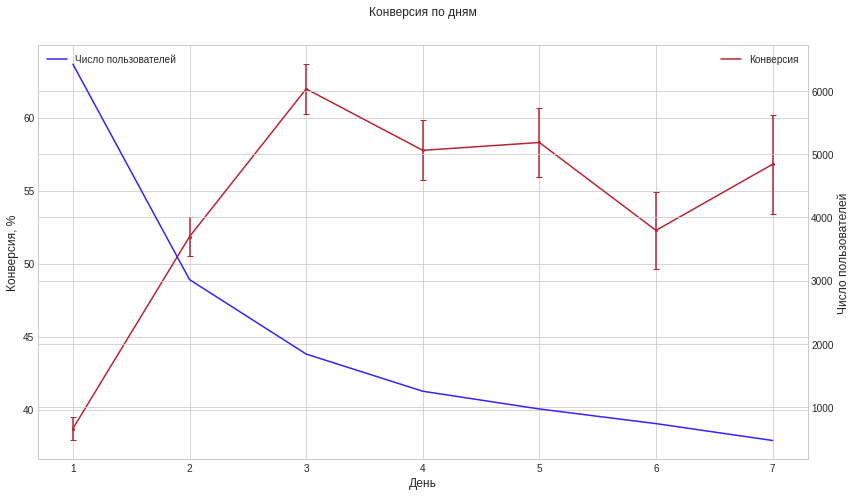

In [203]:
plt.style.use('seaborn-whitegrid')
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(conversion_time['day'], conversion_time['cr_1_3']*100, color = '#bb2233', label = 'Конверсия')
ax1.errorbar(x = conversion_time['day'], y = conversion_time['cr_1_3']*100, yerr = conversion_time['std_1_3']*100,
            fmt='o', markersize=2, capsize=3, color = '#bb2233')

ax1.set_xlabel('День', fontsize=12)
ax1.set_ylabel('Конверсия, %', fontsize=12)
ax1.set_title('Конверсия по дням', y=1.0, pad=30)
ax1.legend(loc = 1)
ax2 = ax1.twinx()
ax2.plot(conversion_time['day'], conversion_time['users'], color = '#3322ff', label = 'Число пользователей')
ax2.tick_params(axis='y')
ax2.set_ylabel('Число пользователей', fontsize=12)
ax2.legend(loc = 2)

fig.tight_layout()
fig.show()

На графике хорошо видно, что несмотря на то, что процент конверсии рос в первые два дня и затем держался в районе 55%, Число пользователей при этом постоянно снижалось. Поэтому значение средней конверсии по всему датасету 47.7% существенно ниже тех значений, что мы видим на графике. Если расчитать конверсию по дням и найти среднее по времени, мы получим более высокий процент.

In [204]:
print('Среднее значение конверсии по времени {:.2%}'.format(conversion_time['cr_1_3'].mean()))

Среднее значение конверсии по времени 53.95%


#### Вывод

Для анализа A/A/В теста мы составили воронку из трех шагов : главная страница - корзина - страница Спасибо.
Из пользователей совершивших первое событие на второй шаг воронки переходит только 50%. На третий шаг переходят 95% из оставшихся. Общая конверсия из первого шага в последний составляет 47.7%, однако если посмотреть на изменение конверсии во времени можно заменить, что большую часть времени конверсия принимает значения в районе 55%.  средняя конверсия, посчитанная по дням, получается заметно выше - почти 54%.

### Изучение результатов А/А/В - теста

Составим таблицу числа уникальных пользователей в каждой группе

In [205]:
unique_group = data.groupby('group')['id'].nunique().to_frame()
unique_group

,id
group,
246,2484
247,2513
248,2537


In [206]:
# Составим таблицу событий по группам

grouped_data = unique_user_df.groupby('group')['event'].value_counts().reset_index(0)
grouped_data

,group,event
event,,
main,246,2450
offer,246,1542
cart,246,1266
typ,246,1200
tutorial,246,278
main,247,2476
offer,247,1520
cart,247,1238
typ,247,1158


In [207]:
grouped_df = pd.DataFrame(index = ['main', 'offer','cart', 'typ', 'tutorial'])
for group in data['group'].unique():
    grouped_df[group] = grouped_data[grouped_data['group']==group]['event']
grouped_df['share_246'] = round((grouped_df[246] / unique_group.iloc[0,0])*100,2)
grouped_df['share_247'] = round((grouped_df[247] / unique_group.iloc[1,0])*100,2)
grouped_df['share_248'] = round((grouped_df[248] / unique_group.iloc[2,0])*100,2)
grouped_df

,246,247,248,share_246,share_247,share_248
main,2450,2476,2493,98.63,98.53,98.27
offer,1542,1520,1531,62.08,60.49,60.35
cart,1266,1238,1230,50.97,49.26,48.48
typ,1200,1158,1181,48.31,46.08,46.55
tutorial,278,283,279,11.19,11.26,11.00


Напишем функцию для проверки равенства пропорций в двух группах с использованием Z-теста и построения доверительного интервала для разности пропорций.

In [208]:
def z_test(all_a, all_b, converted_a, converted_b, title, alpha = .05):
    
    converted_users = np.array([converted_a, converted_b])
    all_users = np.array([all_a, all_b])

    # conversion rate в первой группе:
    cr_a = converted_users[0]/all_users[0]

    # conversion rate во второй группе:
    cr_b = converted_users[1]/all_users[1]
    
    # pooled conversion rate
    cr_pooled = (converted_users[0] + converted_users[1]) / (all_users[0] + all_users[1])
    
    # Стандартное отклонение pooled conversion rate
    cr_sd_pooled=mt.sqrt(cr_pooled*(1-cr_pooled)*(1/all_users[0]+1/all_users[1]))

    # Разница между показателями конверсии в группах
    cr_ab_diff=round((cr_b-cr_a),4)
    
    # Считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = cr_ab_diff / mt.sqrt(cr_pooled * (1 - cr_pooled) * (1/all_users[0] + 1/all_users[1]))
    
    # Ошибка разности пропорций
    cr_ab_ME=round((st.norm.ppf(1-alpha/2)*cr_sd_pooled),6)

    # Стандартное нормальное распределение
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Тест на равенство пропорций количества людей, совершивших событие '+title)
    print()
    print('Н0: Значения пропорций в двух группах равны')
    print('Н1: Значения пропорций в двух группах не равны')
    print()
    print('p-value: ', round(p_value,4))
    print("Уровень статистической значимости alpha = ", alpha)
    print()

    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными') 
    
    # Строим доверительный интервал для разности пропорций
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.errorbar((cr_b-cr_a)*100, 0, xerr = cr_ab_ME*100,
                fmt='o', markersize=8, capsize=20)

    ax.set_xlabel('Разница пропорций, %', fontsize=12)
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Разница пропорций в группах', y=1.0, pad=15)
    plt.axvline(x=0,
                linewidth=2, 
                color='#bb2233', 
                linestyle='-')

    fig.show()
    print()
    print("Разница пропорций в группах :",round(cr_ab_diff*100,2),"%")
    print("Доверительный интервал : [",round((cr_ab_diff*100-cr_ab_ME*100),2),",",round((cr_ab_diff*100+cr_ab_ME*100),2),"]")
    print ("Разница между группами статистически значима, если в доверительный интервал не попадает ноль")

#### Сравнение данных контрольных групп 246 и 247

В общем виде гипотезы для статичтического анализа полученных данных выглядит так:

Н0: Значения пропорций в двух группах равны
<br>
Н1: Значения пропорций в двух группах не равны

Посчитаем p-value и сделаем вывод о наличии или отсутствии статистически достоверного различия между группами.
Будем использовать уровень статистической значимости alpha = 0.05

##### Проверка различий в двух контрольных группах пропорции пользователей, посетивших главную страницу

In [209]:
full1A=unique_group.iloc[0,0]
full2A=unique_group.iloc[1,0]
main1A=grouped_df.iloc[0,0]
main2A=grouped_df.iloc[0,1]
print(full1A, full2A, main1A, main2A)

2484 2513 2450 2476


Тест на равенство пропорций количества людей, совершивших событие "Посещение главной страницы"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.7652
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.1 %
Доверительный интервал : [ -0.76 , 0.56 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


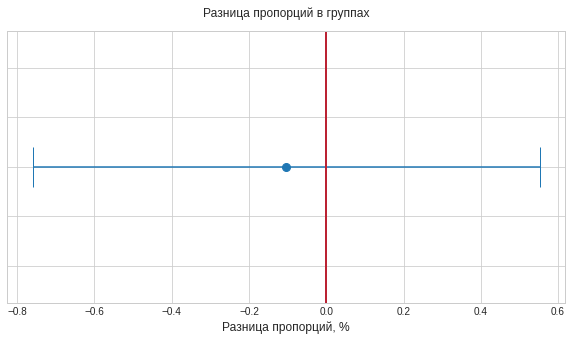

In [210]:
z_test(full1A, full2A, main1A, main2A, '"Посещение главной страницы"')

##### Проверка различий в двух контрольных группах пропорции пользователей, посетивших страницу с предложением

In [211]:
full1A=unique_group.iloc[0,0]
full2A=unique_group.iloc[1,0]
offer1A=grouped_df.iloc[1,0]
offer2A=grouped_df.iloc[1,1]
print(full1A, full2A, offer1A, offer2A)

2484 2513 1542 1520


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы с предложением"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.2486
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -1.59 %
Доверительный интервал : [ -4.29 , 1.11 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


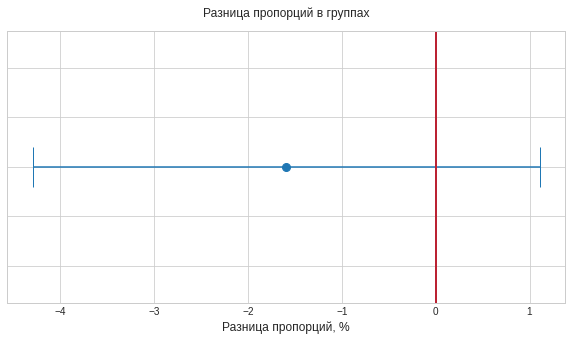

In [212]:
z_test(full1A, full2A, offer1A, offer2A, '"Посещение страницы с предложением"')

##### Проверка различий в двух контрольных группах пропорции пользователей, посетивших корзину

In [213]:
full1A=unique_group.iloc[0,0]
full2A=unique_group.iloc[1,0]
cart1A=grouped_df.iloc[2,0]
cart2A=grouped_df.iloc[2,1]
print(full1A, full2A, cart1A, cart2A)

2484 2513 1266 1238


Тест на равенство пропорций количества людей, совершивших событие "Посещение корзины"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.2295
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -1.7 %
Доверительный интервал : [ -4.47 , 1.07 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


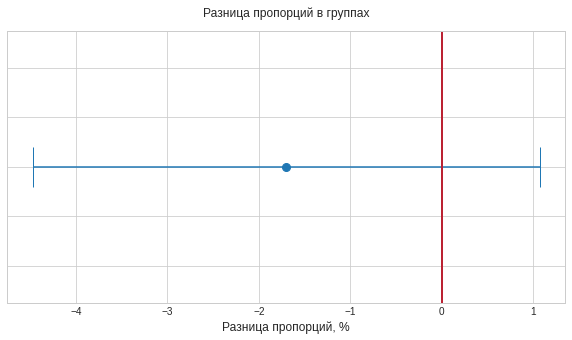

In [214]:
z_test(full1A, full2A, cart1A, cart2A, '"Посещение корзины"')

##### Проверка различий в двух контрольных группах пропорции пользователей, посетивших страницу Спасибо

In [215]:
full1A=unique_group.iloc[0,0]
full2A=unique_group.iloc[1,0]
typ1A=grouped_df.iloc[3,0]
typ2A=grouped_df.iloc[3,1]
print(full1A, full2A, typ1A, typ2A)

2484 2513 1200 1158


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы Спасибо!"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.1144
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -2.23 %
Доверительный интервал : [ -5.0 , 0.54 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


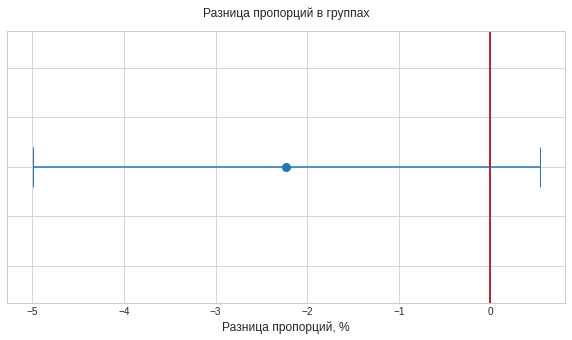

In [216]:
z_test(full1A, full2A, typ1A, typ2A, '"Посещение страницы Спасибо!"')

##### Проверка различий в двух контрольных группах пропорции пользователей, посетивших страницу обучения

In [217]:
full1A=unique_group.iloc[0,0]
full2A=unique_group.iloc[1,0]
tutorial1A=grouped_df.iloc[4,0]
tutorial2A=grouped_df.iloc[4,1]
print(full1A, full2A, tutorial1A, tutorial2A)

2484 2513 278 283


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы обучения"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.9375
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : 0.07 %
Доверительный интервал : [ -1.68 , 1.82 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


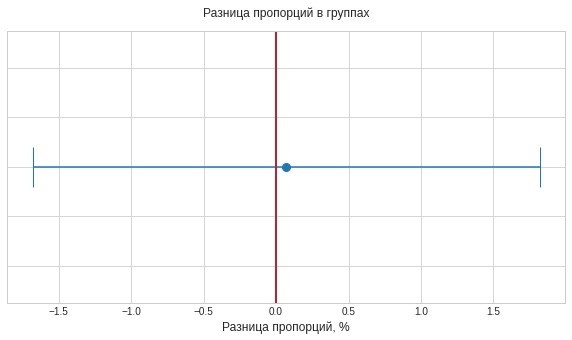

In [218]:
z_test(full1A, full2A, tutorial1A, tutorial2A, '"Посещение страницы обучения"')

#### Сравнение данных тестовой группы 248 и контрольной группы 246

##### Проверка различий в тестовой группе 248 и контрольной группе 246 пропорции пользователей, посетивших главную страницу 

In [219]:
full1A=unique_group.iloc[0,0]
fullB=unique_group.iloc[2,0]
main1A=grouped_df.iloc[0,0]
mainB=grouped_df.iloc[0,2]
print(full1A, fullB, main1A, mainB)

2484 2537 2450 2493


Тест на равенство пропорций количества людей, совершивших событие "Посещение главной страницы"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.2892
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.37 %
Доверительный интервал : [ -1.05 , 0.31 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


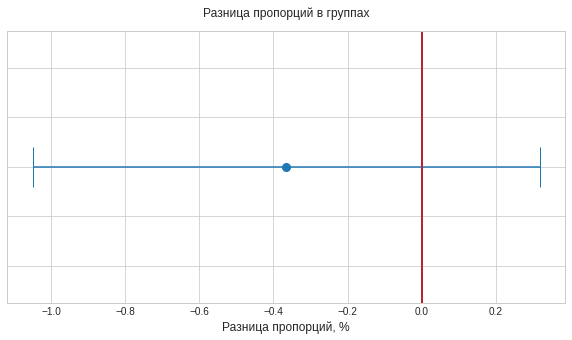

In [220]:
z_test(full1A, fullB, main1A, mainB, '"Посещение главной страницы"')

##### Проверка различий в тестовой группе 248 и контрольной группе 246 пропорции пользователей, посетивших страницу с предложением

In [221]:
full1A=unique_group.iloc[0,0]
fullB=unique_group.iloc[2,0]
offer1A=grouped_df.iloc[1,0]
offerB=grouped_df.iloc[1,2]
print(full1A, fullB, offer1A, offerB)

2484 2537 1542 1531


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы с предложением"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.2085
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -1.73 %
Доверительный интервал : [ -4.43 , 0.97 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


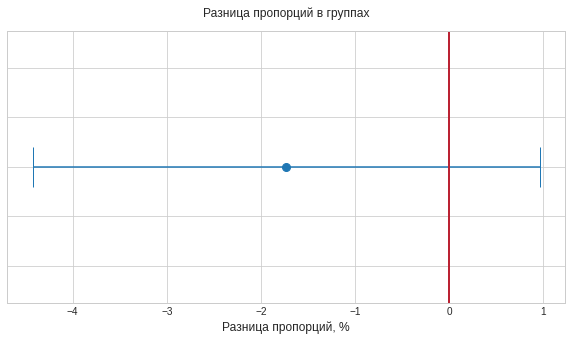

In [222]:
z_test(full1A, fullB, offer1A, offerB, '"Посещение страницы с предложением"')

##### Проверка различий в тестовой группе 248 и контрольной группе 246 пропорции пользователей, посетивших корзину

In [223]:
full1A=unique_group.iloc[0,0]
fullB=unique_group.iloc[2,0]
cart1A=grouped_df.iloc[2,0]
cartB=grouped_df.iloc[2,2]
print(full1A, fullB, cart1A, cartB)

2484 2537 1266 1230


Тест на равенство пропорций количества людей, совершивших событие "Посещение корзины"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.0789
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -2.48 %
Доверительный интервал : [ -5.25 , 0.29 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


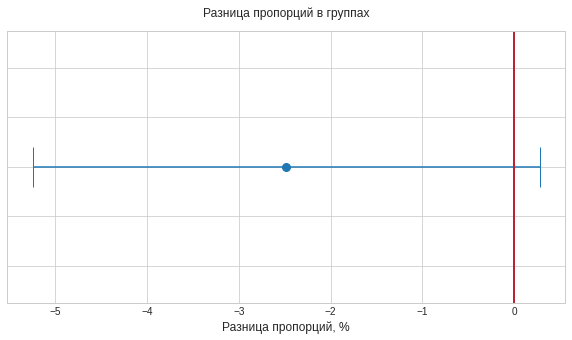

In [224]:
z_test(full1A, fullB, cart1A, cartB, '"Посещение корзины"')

##### Проверка различий в тестовой группе 248 и контрольной группе 246 пропорции пользователей, посетивших страницу Спасибо

In [225]:
full1A=unique_group.iloc[0,0]
fullB=unique_group.iloc[2,0]
typ1A=grouped_df.iloc[3,0]
typB=grouped_df.iloc[3,2]
print(full1A, fullB, typ1A, typB)

2484 2537 1200 1181


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы Спасибо!"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.2118
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -1.76 %
Доверительный интервал : [ -4.52 , 1.0 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


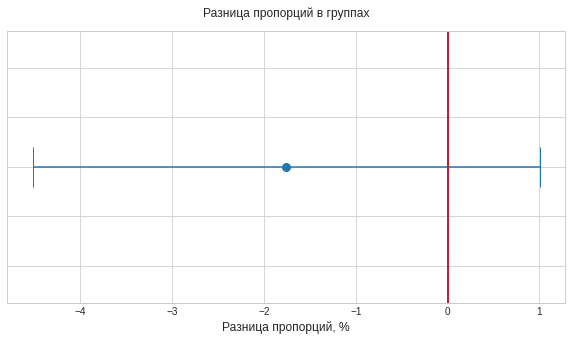

In [226]:
z_test(full1A, fullB, typ1A, typB, '"Посещение страницы Спасибо!"')

##### Проверка различий в тестовой группе 248 и контрольной группе 246 пропорции пользователей, посетивших страницу обучения

In [227]:
full1A=unique_group.iloc[0,0]
fullB=unique_group.iloc[2,0]
tutorial1A=grouped_df.iloc[4,0]
tutorialB=grouped_df.iloc[4,2]
print(full1A, fullB, tutorial1A, tutorialB)

2484 2537 278 279


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы обучения"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.8303
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.19 %
Доверительный интервал : [ -1.93 , 1.55 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


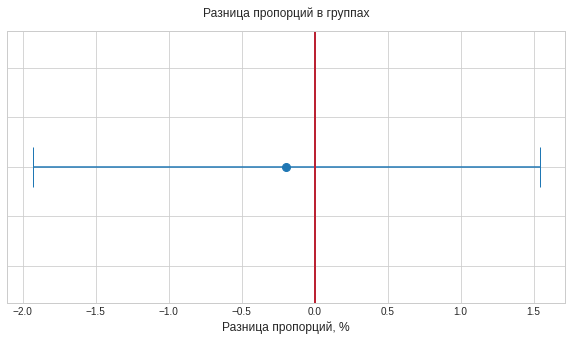

In [228]:
z_test(full1A, fullB, tutorial1A, tutorialB, '"Посещение страницы обучения"')

#### Сравнение данных тестовой группы 248 и контрольной группы 247

##### Проверка различий в тестовой группе 248 и контрольной группе 247 пропорции пользователей, посетивших главную страницу

In [229]:
full2A=unique_group.iloc[1,0]
fullB=unique_group.iloc[2,0]
main2A=grouped_df.iloc[0,1]
mainB=grouped_df.iloc[0,2]
print(full2A, fullB, main2A, mainB)

2513 2537 2476 2493


Тест на равенство пропорций количества людей, совершивших событие "Посещение главной страницы"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.4621
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.26 %
Доверительный интервал : [ -0.95 , 0.43 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


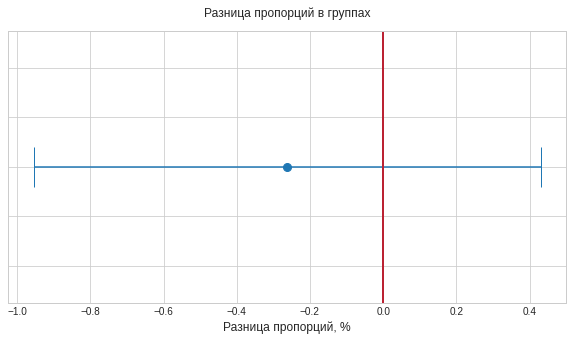

In [230]:
z_test(full2A, fullB, main2A, mainB, '"Посещение главной страницы"')

##### Проверка различий в тестовой группе 248 и контрольной группе 247 пропорции пользователей, посетивших страницу с предложением

In [231]:
full2A=unique_group.iloc[1,0]
fullB=unique_group.iloc[2,0]
offer2A=grouped_df.iloc[1,1]
offerB=grouped_df.iloc[1,2]
print(full1A, fullB, offer1A, offerB)

2484 2537 1542 1531


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы с предложением"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.919
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.14 %
Доверительный интервал : [ -2.84 , 2.56 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


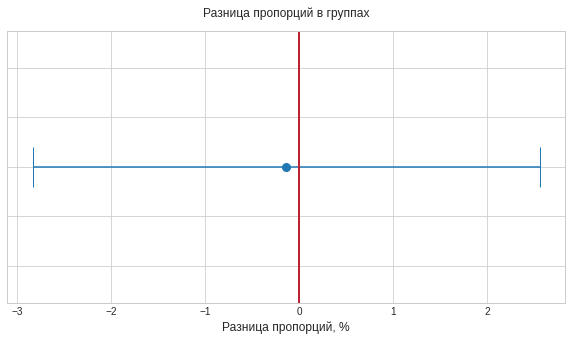

In [232]:
z_test(full2A, fullB, offer2A, offerB, '"Посещение страницы с предложением"')

##### Проверка различий в тестовой группе 248 и контрольной группе 247 пропорции пользователей, посетивших корзину

In [233]:
full2A=unique_group.iloc[1,0]
fullB=unique_group.iloc[2,0]
cart2A=grouped_df.iloc[2,1]
cartB=grouped_df.iloc[2,2]
print(full2A, fullB, cart2A, cartB)

2513 2537 1238 1230


Тест на равенство пропорций количества людей, совершивших событие "Посещение корзины"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.5793
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.78 %
Доверительный интервал : [ -3.54 , 1.98 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


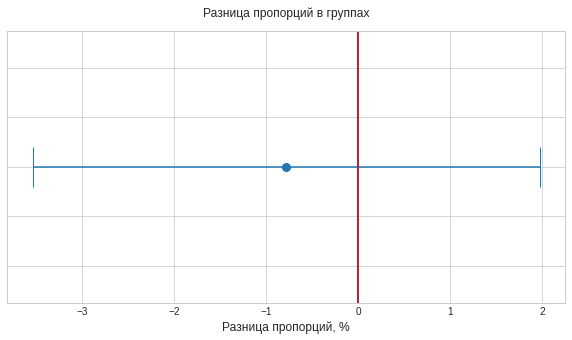

In [234]:
z_test(full2A, fullB, cart2A, cartB, '"Посещение корзины"')

##### Проверка различий в тестовой группе 248 и контрольной группе 247 пропорции пользователей, посетивших страницу Спасибо

In [235]:
full2A=unique_group.iloc[1,0]
fullB=unique_group.iloc[2,0]
typ2A=grouped_df.iloc[3,1]
typB=grouped_df.iloc[3,2]
print(full2A, fullB, typ2A, typB)

2513 2537 1158 1181


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы Спасибо!"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.393
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -1.2 %
Доверительный интервал : [ -3.95 , 1.55 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


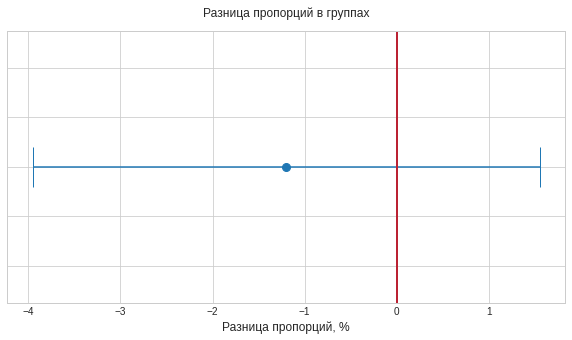

In [236]:
z_test(full2A, fullB, typ1A, typB, '"Посещение страницы Спасибо!"')

##### Проверка различий в тестовой группе 248 и контрольной группе 246 пропорции пользователей, посетивших страницу обучения

In [237]:
full2A=unique_group.iloc[1,0]
fullB=unique_group.iloc[2,0]
tutorial2A=grouped_df.iloc[4,1]
tutorialB=grouped_df.iloc[4,2]
print(full2A, fullB, tutorial2A, tutorialB)

2513 2537 283 279


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы обучения"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.7689
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.26 %
Доверительный интервал : [ -1.99 , 1.47 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


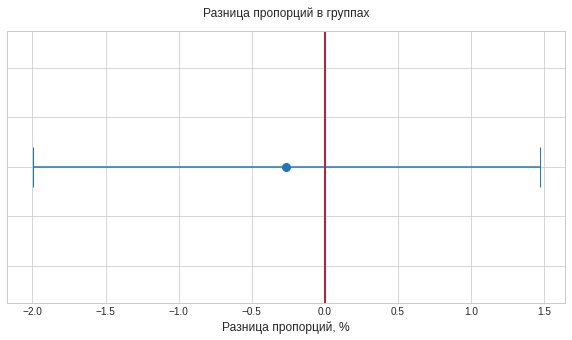

In [238]:
z_test(full2A, fullB, tutorial2A, tutorialB, '"Посещение страницы обучения"')

#### Сравнение данных тестовой группы 248 и объединенных контрольных групп

Объединим контрольные группы в одну

In [239]:
combine_groups_users = unique_group.iloc[0,0]+unique_group.iloc[1,0]
combine_groups_users

4997

In [240]:
grouped_df['combine'] = grouped_df[246] + grouped_df[247]
grouped_df

,246,247,248,share_246,share_247,share_248,combine
main,2450,2476,2493,98.63,98.53,98.27,4926
offer,1542,1520,1531,62.08,60.49,60.35,3062
cart,1266,1238,1230,50.97,49.26,48.48,2504
typ,1200,1158,1181,48.31,46.08,46.55,2358
tutorial,278,283,279,11.19,11.26,11.00,561


##### Проверка различий в тестовой группе 248 и объединенной контрольной группе 246+247 пропорции пользователей, посетивших главную страницу

In [241]:
fullA=combine_groups_users
fullB=unique_group.iloc[2,0]
mainA=grouped_df.iloc[0,6]
mainB=grouped_df.iloc[0,2]
print(fullA, fullB, mainA, mainB)

4997 2537 4926 2493


Тест на равенство пропорций количества людей, совершивших событие "Посещение главной страницы"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.2996
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.31 %
Доверительный интервал : [ -0.9 , 0.28 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


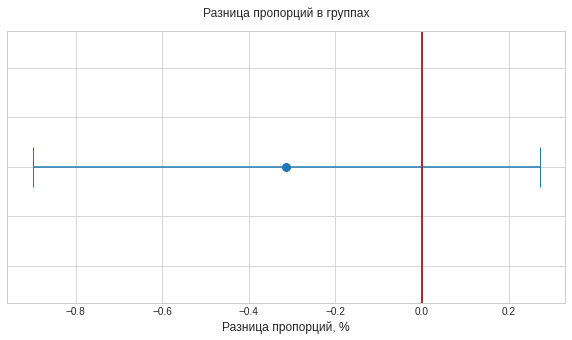

In [242]:
z_test(fullA, fullB, mainA, mainB, '"Посещение главной страницы"')

##### Проверка различий в тестовой группе 248 и объединенной контрольной группе 246+247 пропорции пользователей, посетивших страницу с предложением

In [243]:
fullA=combine_groups_users
fullB=unique_group.iloc[2,0]
offerA=grouped_df.iloc[1,6]
offerB=grouped_df.iloc[1,2]
print(fullA, fullB, offerA, offerB)

4997 2537 3062 1531


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы с предложением"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.4342
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.93 %
Доверительный интервал : [ -3.26 , 1.4 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


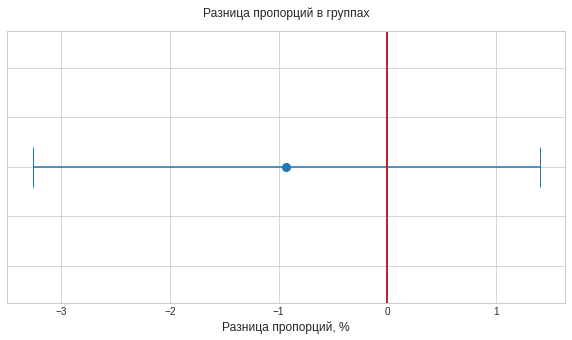

In [244]:
z_test(fullA, fullB, offerA, offerB, '"Посещение страницы с предложением"')

##### Проверка различий в тестовой группе 248 и объединенной контрольной группе 246+247 пропорции пользователей, посетивших корзину

In [245]:
fullA=combine_groups_users
fullB=unique_group.iloc[2,0]
cartA=grouped_df.iloc[2,6]
cartB=grouped_df.iloc[2,2]
print(fullA, fullB, cartA, cartB)

4997 2537 2504 1230


Тест на равенство пропорций количества людей, совершивших событие "Посещение корзины"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.1811
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -1.63 %
Доверительный интервал : [ -4.02 , 0.76 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


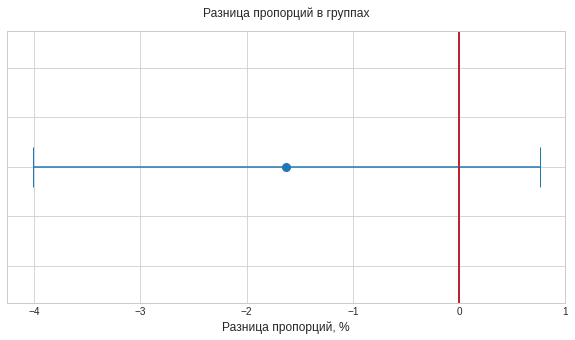

In [246]:
z_test(fullA, fullB, cartA, cartB, '"Посещение корзины"')

##### Проверка различий в тестовой группе 248 и объединенной контрольной группе 246+247 пропорции пользователей, посетивших страницу Спасибо

In [247]:
fullA=combine_groups_users
fullB=unique_group.iloc[2,0]
typA=grouped_df.iloc[3,6]
typB=grouped_df.iloc[3,2]
print(fullA, fullB, typA, typB)

4997 2537 2358 1181


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы Спасибо!"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.5989
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.64 %
Доверительный интервал : [ -3.02 , 1.74 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


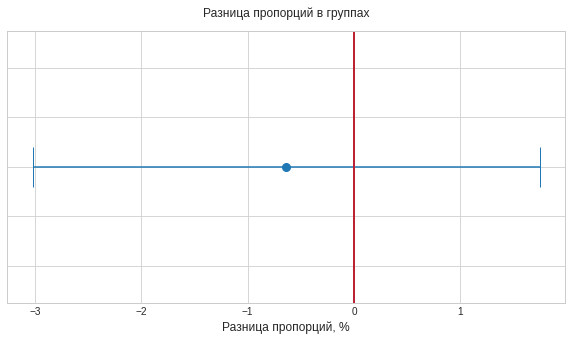

In [248]:
z_test(fullA, fullB, typA, typB, '"Посещение страницы Спасибо!"')

##### Проверка различий в тестовой группе 248 и объединенной контрольной группе 246+247 пропорции пользователей, посетивших страницу обучения

In [249]:
fullA=combine_groups_users
fullB=unique_group.iloc[2,0]
tutorialA=grouped_df.iloc[4,6]
tutorialB=grouped_df.iloc[4,2]
print(fullA, fullB, tutorialA, tutorialB)

4997 2537 561 279


Тест на равенство пропорций количества людей, совершивших событие "Посещение страницы обучения"

Н0: Значения пропорций в двух группах равны
Н1: Значения пропорций в двух группах не равны

p-value:  0.7644
Уровень статистической значимости alpha =  0.05

Не получилось отвергнуть нулевую гипотезу, нет оснований считать значения в группах разными

Разница пропорций в группах : -0.23 %
Доверительный интервал : [ -1.73 , 1.27 ]
Разница между группами статистически значима, если в доверительный интервал не попадает ноль


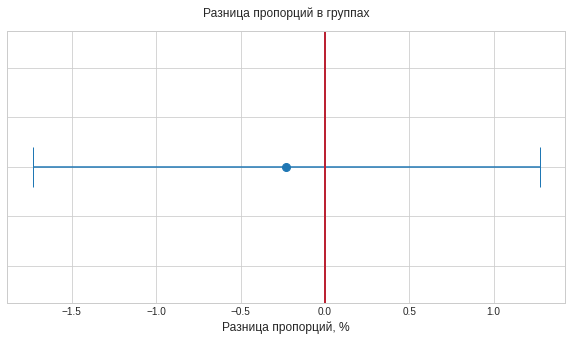

In [250]:
z_test(fullA, fullB, tutorialA, tutorialB, '"Посещение страницы обучения"')

В результате эксперимента статистически значимых различий между группами не обнаружено. Самое маленькое значение p-value = 0.0789 больше выбранного уровня статистической значимости 0.05. Причин изменить этот уровень нет. Мы провели 20 различных тестов, т.е. могли бы получить один ложный результат, но этого не произошло.

### Вывод

В ходе иследования были проведены проверки гипотез о различии в пропорциях пользователей в тестовой и обеих контрольных группах, совершивших различные события. Все тесты показали отсутствия статистически значимого различия между всеми группами при уровне статистической значимости alpha=0.05. Менять шрифт в приложении не имеет смысла.

Для анализа A/A/В теста составили воронку из трех шагов : главная страница - корзина - страница Спасибо. Из пользователей совершивших первое событие на второй шаг воронки переходит только 50%. Со второго на третий шаг переходят 95% пользователей. Общая конверсия из первого шага в последний составляет 47.7%, однако если посмотреть на изменение конверсии во времени можно заменить, что большую часть времени конверсия принимает значения в районе 55%. средняя конверсия, посчитанная по дням, получается заметно выше - почти 54% в связи с резким падением числа событий в первые два дня наблюдений.

При обработке датасета были обнаружены неполные старые данные, которые мы удалили. После этого  стало понятно, что эксперимент проводиля с 1 по 8 августа 2019г. В нем приняли участие 7534 пользователя приложения. У нас есть информация о 243713 событиях, которые совершили эти люди, с медианой 20 событий на человека. События в группах праспределены совольно равномерно, по 77 - 84 тысячи .